In [29]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import RMSprop
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from time import process_time
# os.getcwd()

# New Section

In [57]:
train_dir = 'image/train'
# train_dir = 'image/train_part'
val_dir = 'image/val'
test_dir = 'image/test'

In [31]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')


In [32]:
import numpy as np
from PIL import Image
# how to view an image?; standard method is here 
image_path = 'image/train/NORMAL/IM-0115-0001.jpeg'
img = Image.open(image_path)
img_np = np.array(img)

In [33]:
# add in more transform function

# trans = transforms.Compose([transforms.Resize((300,300)), transforms.ToTensor()])
img_2 = transforms.Resize((300,300))(img)
img_2a = transforms.ToTensor()(img_2) 


In [120]:
# run the following code only once to get the mean and std for the training data, used for later normalization
# notes regarding the normalization function
# 1. ToTensor would already turn the tensor to [0-1], that already makes the things much better (scaling)
# 2. Further normalize this by the mean and standardization for each channel;
# 2a. But it is hard to calculate the mean and standardization for all the training data, so we can 
# 1) calculate a portion, and use that as an approxy, 2)calculate all batches, but use the average of them 3) ignore this step all together
# https://forums.fast.ai/t/image-normalization-in-pytorch/7534/7?u=laochanlam

# transform = transforms.Compose(
#     [
#         transforms.Resize((300,300)),
#         # transforms.Resize(300),
#         transforms.Grayscale(num_output_channels=1),
#         transforms.ToTensor(),
#         # why do we need to normalize at 0.5
#         # transforms.Normalize((0.5, ), (0.5, ))
#     ]
# )

# trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# mean_list = []
# std_list = []
# # we can also permute and change the dimension order
# for i, data in enumerate(trainloader, 0): # start from 0
#     inputs, labels = data
#     mean = inputs[:,0].numpy().mean()
#     std = inputs[:,0].numpy().std()
#     mean_list.append(mean)
#     std_list.append(std)    

# print(np.mean(mean_list))
# print(np.mean(std_list))

0.48224896
0.23586701


In [122]:
transform = transforms.Compose(
    [
        transforms.Resize((300,300)),
        # transforms.Resize(300),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        # why do we need to normalize at 0.5
        transforms.Normalize((0.48), (0.24))
    ]
)


batch_size = 32

trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

valset = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)


In [124]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [17]:
images,labels = next(dataiter)

In [18]:
# Define the first simple model; not working; simple two layer model
# In this simple model; first I don't put in the drop out layer, as the result, the model was overfitting and could not fit at all. 
# Second, I tried to use the same relu layer across board, and the resulting model does not fit. Even though in theory it should work
# created different relu layer for each relu function, shuffled the data set

# for validation dataset, here is the accuracy
# Accuracy: 88.89 %
# Precision: 88.89 %
# Recall: 88.89 %

# class ImageClassificationNet_v1(nn.Module):
#     def __init__(self) -> None:
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3))
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.relu1 =nn.ReLU()

#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3))
#         self.pool2 = nn.MaxPool2d(2,2)
#         self.relu2 = nn.ReLU() 

#         self.fc1 = nn.Linear(in_features=32 * 73 * 73, out_features=128)        
#         self.fc1_relu = nn.ReLU()
#         self.fc1_dropout = nn.Dropout(0.5)        

#         self.fc2 = nn.Linear(128, 1)
#         self.sigmoid = nn.Sigmoid()

    
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu1(x)
#         x = self.pool1(x)

#         x = self.conv2(x)
#         x = self.relu2(x)
#         # x = self.relu1(x) this does not work
#         x = self.pool2(x)

#         x = torch.flatten(x, start_dim=1)

#         x = self.fc1(x)
#         x = self.fc1_relu(x)
#         # x = self.relu1(x)
#         x = self.fc1_dropout(x)

#         x = self.fc2(x)
#         x = self.sigmoid(x)
    
#         return x

# model = ImageClassificationNet_v1().to(device=device)

In [19]:
# model(images).detach().numpy()

In [129]:
# This is model v2
# Accuracy: 91.67 %
# Precision: 91.67 %
# Recall: 91.67 %


class ImageClassificationNet_v2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3))
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3))
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3))
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3))
        self.pool4 = nn.MaxPool2d(2,2)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3))
        self.pool5 = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=512)        
        self.fc2 = nn.Linear(512, 1)
    
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.relu(x)
        x = self.pool5(x)

        x = torch.flatten(x, start_dim=1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.sigmoid(x)
    
        return x
    
model = ImageClassificationNet_v2().to(device=device)

In [130]:
# This model now works; is this because of the drop out layer?
# also important: make sure the data loader has shuffle = True so that each batch contains both positive and negative cases;\

# Accuracy: 85.65 %
# Precision: 85.65 %
# Recall: 85.65 %


# class ImageClassificationNet_v3(nn.Module):
#     def __init__(self) -> None:
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3))
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.relu1 = nn.ReLU()
        
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3))
#         self.pool2 = nn.MaxPool2d(2,2)
#         self.relu2 = nn.ReLU()

#         self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3))
#         self.pool3 = nn.MaxPool2d(2,2)
#         self.relu3 = nn.ReLU()

#         self.fc1 = nn.Linear(in_features=64 * 35 * 35, out_features=64)        
#         self.relu4 = nn.ReLU()
#         self.dropout1 = nn.Dropout(p = 0.5)
        
#         self.fc2 = nn.Linear(64, 1)

#         self.sigmoid = nn.Sigmoid()

    
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu1(x)
#         x = self.pool1(x)

#         x = self.conv2(x)
#         x = self.relu2(x)
#         x = self.pool2(x)

#         x = self.conv3(x)
#         x = self.relu3(x)
#         x = self.pool3(x)

#         x = torch.flatten(x, start_dim=1)
#         x = self.fc1(x)
#         x = self.relu4(x)
#         x = self.dropout1(x)

#         x = self.fc2(x)
#         x = self.sigmoid(x)
#         return x

# model = ImageClassificationNet_v3()

In [131]:
# Try rebuild this simple model;
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [132]:
# Training and Validation Loss
# Get the Accuracy

# both the input and output from the models are tensors;
# If the tensor require auto_grad, we cannot directly convert it to numpy; must do detach() first
# train the full model

t0 = process_time()

NUM_EPOCHS = 20
train_loss_list = []
val_loss_list = []

train_accuracy_list = []
val_accuracy_list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_running_loss =0
    train_running_accuracy = 0 
    for i, data in enumerate(trainloader, 0): # start from 0
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device =device)

        # Forward Pass
        outputs = model(inputs)

        # This is about reshape
        # https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape

        # Loss Function
        loss = loss_fn(outputs, labels.reshape(-1, 1).float())
        accuracy = accuracy_score(outputs.cpu().detach().numpy().round(), labels.cpu().reshape(-1, 1).float())

        # Backward Pass 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss = train_running_loss + loss.item()
        train_running_accuracy = train_running_accuracy + accuracy

        if i % 5 == 0:
            print(f'Epoch {epoch}/{NUM_EPOCHS}, Step {i+1}/{len(trainloader)},'
                    f'Loss: {loss.item():.4f}')
    # find the average of the training loss for each epoch 
    train_running_loss_mean = train_running_loss / len(trainloader)
    train_loss_list.append(train_running_loss_mean)

    train_running_accuracy_mean = train_running_accuracy / len(trainloader)
    train_accuracy_list.append(train_running_accuracy_mean)


    # model evaluation after each epoch
    model.eval()
    val_running_loss = 0
    val_running_accuracy = 0
    
    # Before is to calculate the average loss for each batch; 
    # we can also do the total loss across all predictions; all at once, as how we are evaluting below
    for i, data in enumerate(valloader, 0): # start from 0
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device =device)
        with torch.no_grad():
            outputs = model(inputs)        # loss Function
        loss = loss_fn(outputs, labels.reshape(-1, 1).float())
        val_running_loss = val_running_loss + loss.item()
        
        accuracy = accuracy_score(outputs.cpu().detach().numpy().round(), labels.cpu().reshape(-1, 1).float())
        val_running_accuracy = val_running_accuracy + accuracy

    val_running_loss_mean = val_running_loss / len(valloader)
    val_loss_list.append(val_running_loss_mean)

    val_running_accuracy_mean = val_running_accuracy / len(valloader)
    val_accuracy_list.append(val_running_accuracy_mean)

    t1 = process_time()

print(f"Total time with gpu: {t1-t0}")
    # val_running_accuracy_mean = val_running_accuracy / len(valloader)
    # val_accuracy_list.append(val_running_accuracy_mean)


Epoch 0/20, Step 1/157,Loss: 0.6776
Epoch 0/20, Step 6/157,Loss: 0.8148
Epoch 0/20, Step 11/157,Loss: 0.5868
Epoch 0/20, Step 16/157,Loss: 0.5403
Epoch 0/20, Step 21/157,Loss: 0.5528
Epoch 0/20, Step 26/157,Loss: 0.6149
Epoch 0/20, Step 31/157,Loss: 0.5466
Epoch 0/20, Step 36/157,Loss: 0.4643
Epoch 0/20, Step 41/157,Loss: 0.4421
Epoch 0/20, Step 46/157,Loss: 0.3539
Epoch 0/20, Step 51/157,Loss: 0.3644
Epoch 0/20, Step 56/157,Loss: 0.4176
Epoch 0/20, Step 61/157,Loss: 0.3209
Epoch 0/20, Step 66/157,Loss: 0.3263
Epoch 0/20, Step 71/157,Loss: 0.2462
Epoch 0/20, Step 76/157,Loss: 0.2497
Epoch 0/20, Step 81/157,Loss: 0.1385
Epoch 0/20, Step 86/157,Loss: 0.1764
Epoch 0/20, Step 91/157,Loss: 0.1428
Epoch 0/20, Step 96/157,Loss: 0.1345
Epoch 0/20, Step 101/157,Loss: 0.2288
Epoch 0/20, Step 106/157,Loss: 0.0825
Epoch 0/20, Step 111/157,Loss: 0.1171
Epoch 0/20, Step 116/157,Loss: 0.3405
Epoch 0/20, Step 121/157,Loss: 0.2047
Epoch 0/20, Step 126/157,Loss: 0.1502
Epoch 0/20, Step 131/157,Loss: 0.0

In [ ]:
# train_loss_list_2 = [x.item() for x in train_loss_list]

In [ ]:
# train_loss_list[0].item()

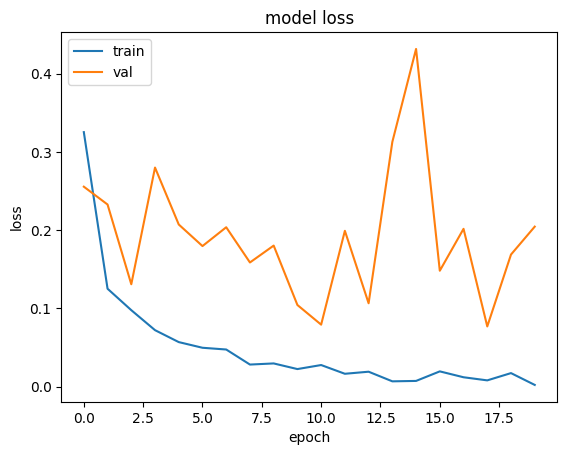

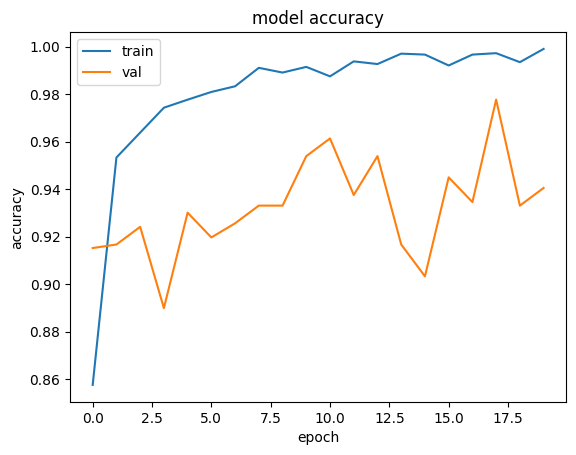

In [133]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# model accuracy 
plt.plot(train_accuracy_list)
plt.plot(val_accuracy_list)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Add in the loss value track
# https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/
# sum up the loss value across batches; calculate the average loss


In [ ]:
# loss function is zero because in this ep

In [35]:
# https://discuss.pytorch.org/t/correct-way-to-calculate-train-and-valid-loss/178974


y_val = []
y_val_hat = []
model.eval()  # this line needs to be added there. 
for i, data in enumerate(valloader, 0):
    inputs, y_val_temp = data
    with torch.no_grad():

        y_val_hat_temp = model(inputs).round()
    
    y_val.extend(y_val_temp.numpy())
    y_val_hat.extend(y_val_hat_temp.numpy())

# %%

RuntimeError: Mismatched Tensor types in NNPack convolutionOutput

In [ ]:
print(f'Performance metrics for validation datasets: \n')

acc = accuracy_score(y_val, y_val_hat)
print(f'Accuracy: {acc*100:.2f} %')

precision = precision_score(y_val, y_val_hat)
print(f'Precision: {acc*100:.2f} %')

recall = recall_score(y_val, y_val_hat)
print(f'Recall: {acc*100:.2f} %')

Performance metrics for validation datasets: 



NameError: name 'y_val' is not defined

In [ ]:
y_test = []
y_test_hat = []
for i, data in enumerate(testloader, 0):
    inputs, y_test_temp = data
    with torch.no_grad():
        y_test_hat_temp = model(inputs).round()
    
    y_test.extend(y_test_temp.numpy())
    y_test_hat.extend(y_test_hat_temp.numpy())

In [ ]:
y_train = []
y_train_hat = []
for i, data in enumerate(trainloader, 0):
    inputs, y_train_temp = data
    with torch.no_grad():
        y_train_hat_temp = model(inputs).round()
         
    y_train.extend(y_train_temp.numpy())
    y_train_hat.extend(y_train_hat_temp.numpy())


In [ ]:
y_train_hat

In [ ]:
print(f'Performance metrics for training datasets: \n')

acc = accuracy_score(y_train, y_train_hat)
print(f'Accuracy: {acc*100:.2f} %')

precision = precision_score(y_train, y_train_hat)
print(f'Precision: {acc*100:.2f} %')

recall = recall_score(y_train, y_train_hat)
print(f'Recall: {acc*100:.2f} %')

In [ ]:
print(f'Performance metrics for test datasets: \n')

acc = accuracy_score(y_test, y_test_hat)
print(f'Accuracy: {acc*100:.2f} %')

precision = precision_score(y_test, y_test_hat)
print(f'Precision: {acc*100:.2f} %')

recall = recall_score(y_test, y_test_hat)
print(f'Recall: {acc*100:.2f} %')